# <center>Practical 07: Robot Control</center>

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as linalg
import pickle

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

from Robot import *
from Helper import *
from Renderer import Renderer as PenguinPiRenderer
from Renderer1D import RobotRenderer

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

**See docstring for functions in support scripts**: If you want to know what a function does, just click somewhere within the parentheses that enclose the arguments and hit SHIFT+TAB. If there's a + button at the top of the popup tooltip, this means the documentation spans a few lines, click it to show the full docstring, then scroll up.

## 1. PID Control - 1D Linear System

Recall our 1D robot 

<img src="Support/images/1DRobot.png" width="400" height="400" align="center">

We want to implement a controller that generates the signal $\mathbf{u}_t$ required to bring the robot to a desired state $\mathbf{x}_d$

We first define our robot in State-Space Form:

<center> $\mathbf{x}_{t+1} = A\mathbf{x}_t + B\mathbf{u}_t$ </center>
<center> $\mathbf{y}_{t} = C\mathbf{x}_t$, </center>

where $A$ corresponds to the state matrix, $B$ defines the input or control matrix and $C$ corresponds to the output matrix. Our robot will be represented by the Python class ``Robot1D``

In [3]:
class Robot1D(object):

    """
    A simple implementation of a 1D robot in state-space form
    The constant MAX_CONTROL bounds the magnitude of the control signal that can be applied to the robot 
    """

    MAX_CONTROL = 500 # originally 5, but we set it to large during lecture + prac session; large number so we can essentially ignore the actuator limits
    
    def __init__(self, A=np.eye(2), B=np.array([[0],[0]]), C=np.array([0, 0]), initial_state=np.array([[10],[0]])):
        
        """
        Initialize a new model. 
        :param A: nxn state matrix, where n = state dimensionality
        :param B: nx1 input matrix, where n = state dimensionality
        :param C: 1xn input matrix, where n = state dimensionality
        :param initial_state: 2x1 vector with the initial state of our system
        """
        self.A = A
        self.B = B
        self.C = C
        self.state = initial_state
                
    def drive(self, control_u=10):
        """
        Update the system's state given a new control input
        :param control_u: Control input
        """
        # Make sure control signal is within -MAX_CONTROL < control_u < MAX_CONTROL
        clip_control = np.clip(control_u, -self.MAX_CONTROL, self.MAX_CONTROL) # acknowledging the limits of the robot
        state_t1 = self.A @ self.state + self.B * clip_control
        self.state = state_t1
            
    def get_state(self):
        """
        Get the system's current state
        """
        return self.state
    
    def get_output(self):
        """
        Get the system's ouput (position of the robot along the 1D line)
        """
        return self.C @ self.state
                
    def get_error(self, desired_x):
        """
        This method measures the error (scalar) between the current robot's state and the desired state
        :param desired_x: Desired state (i.e., position) on the 1D line
        """
        return (desired_x - self.state)[0][0]

### Define our PID Controller

Let us now define our PID controller. Recall the formulation of a PID controller in the discrete domain:

<center>$\mathbf{u}_t = K_p \mathbf{e}_t + K_i \sum_{k = 0}^t \mathbf{e}_k \Delta t + K_d \frac{\mathbf{e}_t - \mathbf{e}_{t-1}}{\Delta t}$, where</center>

- $K_p, K_i, K_d$ are the proportional, integral and derivative gains
- $\mathbf{e}_t$ is the error at time $t$. In our case $\mathbf{e}_t = \mathbf{x}_d - \mathbf{x}_t$
- $\Delta t$ is the rate at which the PID controller is updated

In [10]:
class PID(object):
    
    """A simple PID controller."""

    def __init__(self, system=None, desired_state=None, K_p=0, 
                 K_i=0, K_d=0, update_rate=0.001): # for the purposes of right now, we use fast update, but update_rate originally 0.05 
        
        """
        Initialize a new PID controller.
        :param system: The robot system to controlled
        :param desired_state: The goal state that the PID will try to achieve for the robotic system
        :param K_p: The value for the proportional gain K_p
        :param K_i: The value for the integral gain K_i
        :param K_d: The value for the derivative gain K_d
        :param update_rate: Rate at which the PID controller is updated. 
        """
        self.system = system
        self.set_point = desired_state
        self.K_p = K_p
        self.K_i = K_i
        self.K_d = K_d
        self.update_rate = update_rate
        
        # Last observed error between desired state (self.set_point) and the current state of the system
        self.last_error = self.system.get_error(self.set_point)
        
        # Accumulator for integral term
        self.integral = 0
        
        # Last time the controller was called
        self.last_time = time.time()
        
        # Last control command provided to the system
        self.last_control = 0
        
    def compute_control(self):
        
        """
        This method computes the next control signal u_t so as to reduce the error
        between the robot's current state and the desired state (self.set_point)
        """
        
        current_time = time.time()
        
        # We compute the time elapsed (i.e., delta_time) since the last call to the controller
        # If current_time - self.last_time is zero, we set elapsed_time = 1e-16 to avoid division by zero
        delta_time = current_time - self.last_time if current_time - self.last_time else 1e-16
        
        # We return last control signal if time elapsed since last call is less than self.update_rate
        if delta_time < self.update_rate:
            return self.last_control
        
        # Compute error
        error_t = self.system.get_error(self.set_point)
        
        # Compute integral and derivative terms
        derivative = (error_t - self.last_error) / delta_time
        self.integral += error_t * delta_time
        
        # Compute new control
        new_control = self.K_p * error_t + self.K_i * self.integral + self.K_d * derivative
        
        # Update self.last_error, self.last_time and self.last_control signal with new values
        self.last_error = error_t
        self.last_time = current_time
        self.last_control = new_control
                
        return new_control

### Test the Controller

Let us now test our controller. We consider the following values in our current test case:
- The robot initial state is $\mathbf{x}_0 = (10, 0)$. The desired states is $\mathbf{x}_d = (50, 0)$
- The PID gains are set to $K_p=2, K_i=0, K_d=0.001$
- Our control loop lasts one second

In [22]:
# Define state, input and output matrices
A = np.array([[1, 0], [1, 0]])
B = np.array([[0.5],[0]])
C = np.array([1, 0])

# Create a robot and define desired state
bot = Robot1D(A=A, B=B, C=C, initial_state=np.array([[10],[0]]))
desired_x = np.array([[50],[0]])

# Create a PID controller
pid = PID(system=bot, desired_state=desired_x, K_p=1.5, K_i=0, K_d=0.001)

# Variables needed for plotting
u, sim_time, error, robot_state = [], [], [], []

# Keep track of time within the control loop
start_time = time.time()
last_time = start_time

# This is our control loop. Currently we call our controller for 1 second
while time.time() - start_time < 1:
    current_time = time.time()
    
    # Call controller to get new signal u_t
    u_t = pid.compute_control()
    # Apply control to robot
    bot.drive(u_t)

    # Save values for plotting
    sim_time += [current_time - start_time]
    error += [bot.get_error(desired_x)]
    u += [u_t]
    robot_state += [bot.get_output()]
    
    last_time = current_time
    
    time.sleep(0.02)

### Visualise the Resulting Trajectories

Let us now plot the changes observed in error (right-bottom), control signal (right-top), and robot's state (left) 

<IPython.core.display.Javascript object>


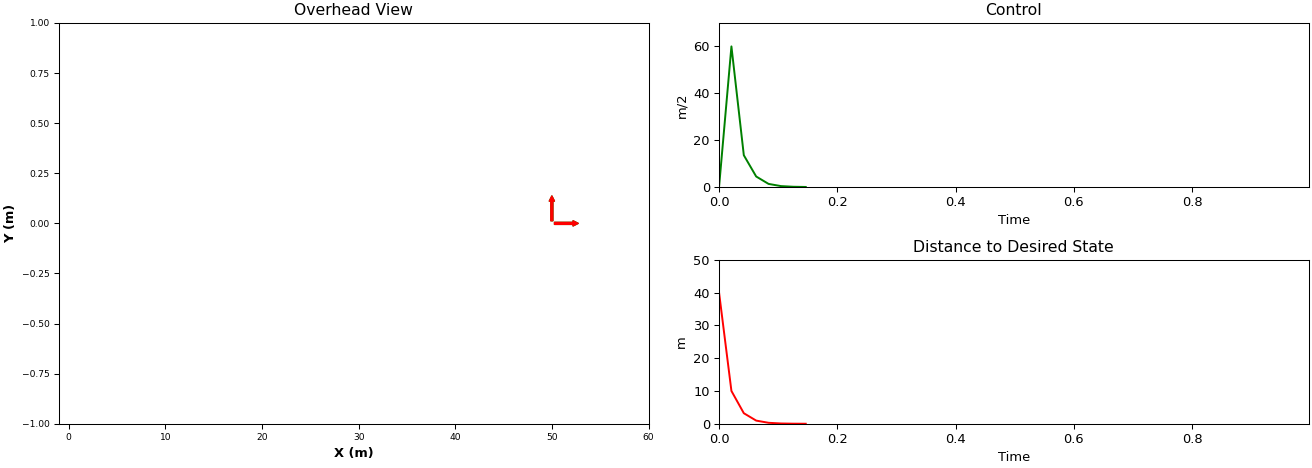

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=48), B…

In [23]:
# Define renderer and start animation
rend = RobotRenderer.Instance()
rend.initialize(robot_state, u, error, sim_time, desired_x, dt_render=0.3)

### <font color='blue'>FLUX Question (1pt): </font> 
What happens to the tracking error when we increase the proportional gain $K_p$?

## 2. PID Control - Differential Drive Vehicle

Recall the kinematic model of our PenguinPi robot:

<img src="Support/images/PenguinPi_Model.png" width="400" height="400" align="center">

In this model, the state is defined by a 3D vector ($x, y, \theta)$ and the control input corresponds to the linear and angular velocities $(v, \omega)$.

### Define a Move to Goal Controller

Consider the problem of moving the PenguinPi to a goal point $(x_g, y_g)$. How can we solve this control problem?

Let us define 2 proportional controllers:
- One controller with gain $K_{pw}$ that will turn the robot toward the goal. This controller determines the angular velocity $\omega_k$ according to

<center> $\omega_k = K_{pw} (\theta_g - \theta_r)$, </center> 

where $\theta_g$ corresponds to the angle to the goal relative to the heading of the robot and $\theta_r$ is the heading of the robot at time $k$.

- One controller with gain $K_{pv}$ that will keep moving the robot forward until it reaches the goal. This controller determines the angular velocity $v_k$ according to

<center> $v_k = K_{pv}\sqrt{(y_g-y_k)^2+(x_g-x_k)^2}$ </center> 

We have combined these 2 controllers into a single class called ``MoveToGoalController``. Two helper functions ``get_distance_robot_to_goal(.)`` and ``get_angle_robot_to_goal(.)`` have been defined to compute $(\theta_g - \theta_r)$ and $\sqrt{(y_g-y_k)^2+(x_g-x_k)^2}$ respectively.


#### TODO: 
- Compute both $\omega_k$ and $v_k$

In [24]:
class MoveToGoalController(object):
    
    """A simple move to goal proportional controller"""

    def __init__(self, robot=None, K_pw=0, K_pv=0):
        """
        Initialize a new move to goal proportional controller
        :param robot: The robotic system to controlled
        :param K_w: The proportional gain for the angular velocity
        :param K_v: The proportional gain for the linear velocity
        """
        self.robot = robot
        self.K_pw = K_pw
        self.K_pv = K_pv
        
        
    def run(self, goal_position=np.zeros(2), threshold=1e-3, delta_time=0.01):
        """
        Run control loop until the robot reaches the goal_position
        :param goal_position: Desired goal position
        :param threshold: Value used to determine whether robot has reached 
                          the goal location
        """
        last_time = time.time()
        
        states = []
        controls = []
        initial_state = self.robot.get_state()
        
        distance_to_goal = get_distance_robot_to_goal(initial_state, goal_position)
        desired_heading = get_angle_robot_to_goal(initial_state, goal_position)
                
        states.append(initial_state)
        
        while distance_to_goal > threshold:
            
            # ---------- TODO Compute control input----------------
            v_k = 0
            v_k = self.K_pv * distance_to_goal
            w_k = 0
            w_k = self.K_pw * desired_heading
            # -----------------------------------------------------
            
            # Apply control to robot
            self.robot.drive(v_k, w_k, delta_time)
            new_state = self.robot.get_state()
            
            # Keep track of variables for plotting
            controls.append([v_k, w_k])
            states.append(new_state)
                        
            # Update distance and desired heading
            distance_to_goal = get_distance_robot_to_goal(new_state, goal_position)
            desired_heading = get_angle_robot_to_goal(new_state, goal_position)
                       
        return states, controls

### Test the Controller

Let us now visualise how our PenguinPi robot moves toward a goal position using the control signals computed by our ``MoveToGoalController``

We consider the following values in our current test case:
- The robot initial state is $\mathbf{x}_0 = (-1.5, -1.5, \frac{\pi}{3})$. The desired states is $\mathbf{x}_d = (1.0, 1.0)$.
- The proportional gains are set to $K_{pw}=5, K_{pv}=2$
- Our control loop lasts until $\sqrt{(y_g-y_k)^2+(x_g-x_k)^2} > 0.001$

<IPython.core.display.Javascript object>


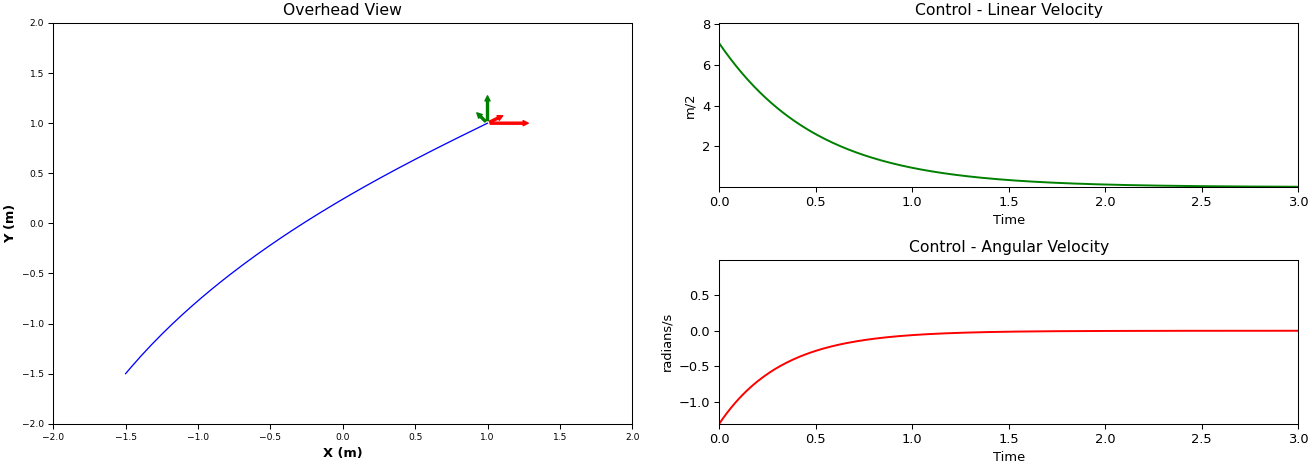

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=405), …

In [29]:
# Define robot, desired goal and delta time
bot = PenguinPi(init_state=np.array([-1.5, -1.5, np.pi/3]))
desired_goal = np.array([1.0, 1.0, 0])
delta_t = 0.01

# Instantiate controller and compute sequence of control signals
controller = MoveToGoalController(bot, K_pw=5, K_pv=2)
robot_states, robot_controls = controller.run(goal_position=desired_goal, delta_time=delta_t)

# Define variables for animation
array_states = np.array(robot_states)
array_controls = np.array(robot_controls)

# Define renderer and start animation
rend = PenguinPiRenderer.Instance()
rend.initialize(array_states, array_controls, target_pose=desired_goal, dt_data=delta_t)

### <font color='blue'>FLUX Question (1pt): </font> 
Currently $K_{pw} > K_{pv}$, what happens if we set $K_{pw} = K_{pv} = 5$ ?

## 3. LQR - Discrete Time Infinite Horizon

Given a linear system with equations:

<center> $\mathbf{x}_{t+1} = A\mathbf{x}_t + B\mathbf{u}_t$ </center>
<center> $\mathbf{y}_{t} = C\mathbf{x}_t$, </center>

where $A$ corresponds to the state matrix, $B$ defines the input or control matrix and $C$ corresponds to the output matrix.

We wan to find $\mathbf{u}$ so as to minimize the cost function

<center>$J = \sum_{t=0}^{\infty} ((\mathbf{x}_t-\mathbf{x}_g)^TQ(\mathbf{x}_t-\mathbf{x}_g) + \mathbf{u}_t^TR\mathbf{u})$, </center> 

where $Q$ defines the state cost and $R$ corresponds to the control cost.

To do so, we want to implement a **LQR Infinite Horizon Controller** with gain  
<center> $K = (R+B^TPB)^{-1}(B^TPA)$ </center>

**TODO:**
- Complete the definition of the controller's gain K. You can use the function ``linalg.inv(.)`` to compute the inverse of a matrix
- Keep in mind that $P$ is defined by the class attribute ``self.P``

In [30]:
class DiscreteInfiniteLQR(object):
    
    """A simple LQR Infinite Horizon controller."""

    def __init__(self, Q=np.eye(2), R=0.3):
        
        """
        Initialize a new LQR controller.
        :param Q: State cost
        :param R: Control cost
        """
        
        self.Q = Q
        self.R = R
        
        # Controller gain to be defined once LQR function is solved
        self.K = np.zeros(2)
        self.P = np.eye(2)
                
    def solve(self, system):
        """
        Compute controller gain for a given system
        :param system: Linear system for which a control law needs to be
                       computed
        """
        A = system.A
        B = system.B
        
        # Solve Riccati Equation
        self.P = linalg.solve_discrete_are(A, B, self.Q, self.R)
                
        # ----------------------- TODO: Compute the controller's gain ------------
        self.K = linalg.inv(self.R + B.T @ self.P @ B) @ (B.T @ self.P @ A)
        
    def get_gain(self):
        """
        Get access to controller gain
        """
        return self.K
        
        

### Test the Controller

Let us now take a look at the state and control trajectories that can obtained using our LQR implementation. Keep in mind that the optimal controller is defined as

<center>$\mathbf{u_t} = -K(\mathbf{x_t} - \mathbf{x_g})$, </center>

where $\mathbf{x_g}$ corresponds to the desired state.

We consider the same test case used with our PID controller:
- The robot initial state is $\mathbf{x}_0 = (10, 0)$. The desired states is $\mathbf{x}_d = (50, 0)$
- Our control loop lasts one second

In [39]:
# Create an instance of our 1D robot system
A = np.array([[1, 0], [1, 0]])
B = np.array([[0.5],[0]])
C = np.array([1, 0])

bot = Robot1D(A=A, B=B, C=C, initial_state=np.array([[10], [0]]))

# Define the state and control costs
Q = np.array([[1,0],[0,0]])
R = 0.3

# Create an instace of our controller and solve the LQR problem
lqr = DiscreteInfiniteLQR(Q=Q, R=R)
lqr.solve(bot)

# Define desired state
desired_x = np.array([[50],[0]])

# Keep track of values for plotting
u_list, sim_time, error, y_list = [], [], [], []

# Keep track of time within the control loop
start_time = time.time()
last_time = start_time

# This is our control loop. Currently we call our controller for 1 second
while time.time() - start_time < 1:
    current_time = time.time()
    
    # Get current state of the system
    x_t = bot.get_state()
    # Get output 
    y_t = bot.get_output()
    
    # Determine and apply control
    u_t = (-lqr.K @ (x_t - desired_x))[0]
    bot.drive(u_t)
    
    # Keep track of variable for plotting
    sim_time += [current_time - start_time]
    u_list += [u_t]
    y_list += [y_t]
    error += [bot.get_error(desired_x)]
        
    last_time = current_time
    
    time.sleep(0.02)

### Visualise the Resulting Trajectories

Let us now plot the changes observed in error (right-bottom), control signal (right-top), and robot's state (left) 

<IPython.core.display.Javascript object>


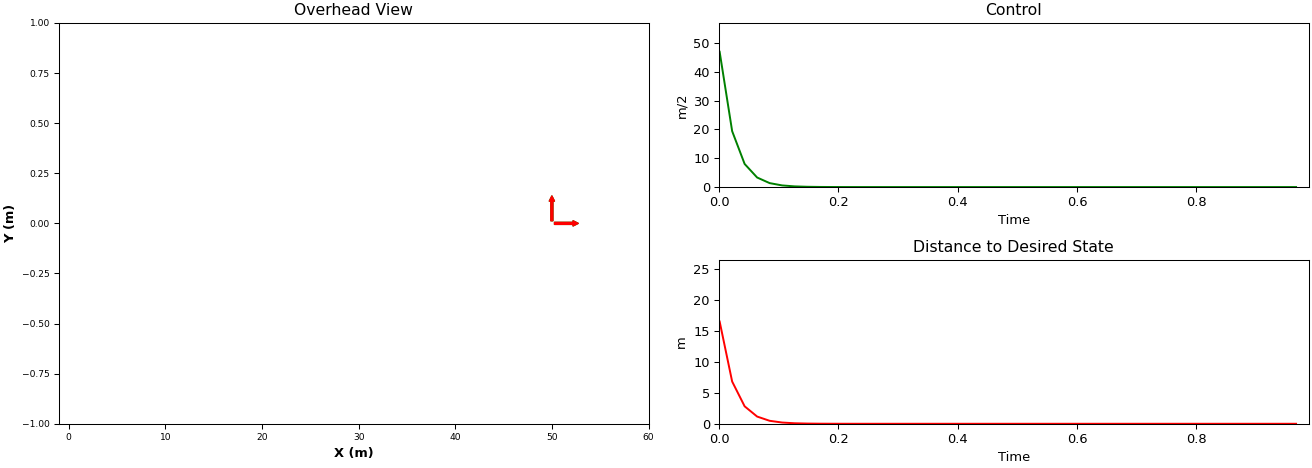

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=47), B…

In [40]:
# Define renderer and start animation
rend = RobotRenderer.Instance()
rend.initialize(y_list, u_list, error, sim_time, desired_x, dt_render=0.3)

### <font color='blue'>FLUX Questions (1pt each): </font> 
1. What happens if we make the control cost more important than the state cost (i.e., modify R and Q variables)?
2. Now that you have seen the trajectories that can be obtained using a PID or LQR controller, why do you think the PID controller fails to reach the desired state?

# Coding Exercises

## Exercise 1 (3 pts): Implement a Pose Controller for the PenguinPi Robot

In Part 2 of this notebook, we defined a proportional controller that brings our PenguinPi Robot to a desired location in space. However, we did not control the robot's orientation.

We now want to define a controller that brings our robot to a goal pose that includes a desired orientation $(x_g, y_g, \theta_g)$. This controller, represented by the class ``MoveToGoalPoseController``, combines three proportional controllers with gains $K_\rho, K_\alpha, K_\beta$. 

The control law of this new controller is defined as follows

<center>
$\begin{equation}
\begin{split}
v_t &= K_\rho \rho\\
\omega_t &= K_\alpha \alpha + K_\beta \beta, \\
\end{split}
\end{equation}$
</center>

where 
- $\rho = \sqrt{(y_g-y_t)^2+(x_g-x_t)^2}$ corresponds to the distance between the robot and the goal position;
- $\alpha = \text{tan}^{-1} \frac{(y_g-y_t)}{(x_g-x_t)} - \theta_t$ defines the angle to the goal relative to the heading of the robot; and
- $\beta = \theta_g -\theta_t - \alpha$ corresponds the angle between the robot's position and the goal position plus the goal angle.

**Things to keep in mind**
- Compute $\rho$, $\alpha$, and $\beta$ with the help of the functions defined in ``Helper.py`` (see scripts in *Support* folder)
- Limit $\beta$ to the range $[-\pi, \pi]$ to prevent unstable behavior. You can use the helper function ``clamp_angle(.)`` to do so.

**Grading**
- Make sure that the ``run(.)`` function returns two arrays. The first array of dimensions 3xN corresponds to states. The second array of dimensions 2XN corresponds to the inputs (or controls) computed by your controller
- <font color='red'>**Remove all print statements before submitting your solution**</font> 

In [ ]:
class MoveToPoseController(object):
    
    """A simple move to pose proportional controller"""

    def __init__(self, robot=None, K_rho=0, K_alpha=0, K_beta=0):
        """
        Initialize a new move to pose proportional controller
        :param robot: The robotic system to controlled
        :param K_rho: The proportional gain for the linear velocity 
        :param K_alpha: First proportional gain for the angular velocity
        :param K_beta: Second proportional gain for the angular velocity
        """
        self.robot = robot
        self.K_rho = K_rho
        self.K_alpha = K_alpha
        self.K_beta = K_beta
        
        
    def run(self, goal_position=np.zeros(3), threshold=1e-3, delta_time=0.01):
        """
        Run control loop until the robot reaches the goal_position
        :param goal_position: Desired goal position
        :param threshold: Value used to determine whether robot has reached 
                          the goal location
        :returns: Tuple of arrays. A 3DxN array for the system states and a 2DxN array for control inputs
        """
        last_time = time.time()
        
        states = []
        controls = []
        initial_state = self.robot.get_state()
        states.append(initial_state)
        
        # ---------- TODO 1: Compute rho, alpha and beta
                        
        # ------------ TODO 2: Implement the control loop
        while rho > threshold:
            
            # 1.Compute the new control input
            
            # 2. Apply control to robot and get new state
            
            # 3. Keep track of control and states for plotting. Use the states and controls list for this
                        
            # 3. Update rho, alpha and beta
                       
        return np.array(states), np.array(controls)

### Test your Solution

**Visually**: The position and orientation of your robot should match the target pose currently displayed as a fixed 2D coordinate frame at (1.0, 1.0)

**Numerically**: Compare your states and controls to the values in the test file ``Support/data/MoveToPose_TestCase.pk``:

```python
import pickle

with open('Support/data/MoveToPose_TestCase.pk', 'wb') as read_from:
    test_values = pickle.load(read_from)
    
test_controls = test_values['control']
test_states = test_values['states'
```

In [ ]:
# Define robot, desired goal and delta time
bot = PenguinPi(init_state=np.array([-1.5, -1.5, 0]))
desired_goal = np.array([1.0, 1.0, np.pi/2])
delta_t = 0.01

# Instantiate controller and compute sequence of control signal
controller = MoveToPoseController(bot,  K_rho=3, K_alpha=7, K_beta=-1)
robot_states, robot_controls = controller.run(goal_position=desired_goal, delta_time=delta_t)

# Define renderer and start animation
rend = PenguinPiRenderer.Instance()
rend.initialize(robot_states, robot_controls, target_pose=desired_goal, dt_data=delta_t)

## Exercise 2 (3 pts): Implement a Discrete Time Finite Horizon LQR Controller

The solution to the discrete-time finite horizon LQR problem is given by the following algorithm:

1. Set $P_N$ = Q
2. For $t = N,\dots,1$

<center>$P_{t-1} = Q + A^TP_tA - A^TP_tB(R+B^TP_tB)^{-1}B^TP_tA$</center>

3. For $t = 0,\dots,N-1$, define
<center>$K_{t} = -(R+B^TP_{t+1}B)^{-1}B^TP_{t+1}A$</center>

4. For $t = 0,\dots,N-1$, optimal $\mathbf{u}_t$ is given by <center>$\mathbf{u}_t = -K_t(\mathbf{x}_t - \mathbf{x}_g$)</center>

You are tasked with defining the corresponding ``DiscreteFiniteLQR`` Python class. A skeleton class is provided below. 

**Please keep in mind**
- ``self.P`` = $[P_1, P_2,\dots,P_N]$. Each time you compute a new P matrix, add it to the self.P attribute (defined as a list) using the method ``self.P.append(new_P)``. All P matrices are needed for the computation of the gains.
- ``self.K`` = $[K_0, K_1,\dots,K_{N-1}]$. Each time you compute a new gain K, add it to the self.K attribute (defined as a list) using the method ``self.K.append(new_K)``. All K matrices are needed for the computation of the control inputs.

**Grading**
- You will be graded based on the output of the ``run_control_loop_method(.)``. Please make sure that your solution returns the expected variables with the correct type.
- <font color='red'>**Remove all print statements before submitting your solution**</font> 

In [ ]:
class DiscreteFiniteLQR(object):
    
    """A simple LQR controller."""

    def __init__(self, Q=np.eye(2), R=0.3):
        
        """
        Initialize a new LQR controller.
        :param Q: State cost
        :param R: Control cost
        """
        
        self.Q = Q
        self.R = R
        
        # List of solutions to the Riccati Equation for each iteration
        self.P = []
        # List of controller gains for each iteration
        self.K = []
        
        
    def solve(self, system, horizon=20):
        
        """
        Compute controller gain for a given system
        :param system: Linear system for which a control law needs to be
                       computed
        :param horizon: Planning horizon
        """
        
        A = system.A
        B = system.B
        
        # Set P_N = Q
        self.P.append(self.Q)
        
        # ---------------- TODO 1: Compute all P matrices ---------------
        # Do not forget to add each new P matrix to the class attribute self.P
        # ---------------------------------------------------------------
        
        for i in range(horizon, 0, -1):
            pass
        
        # ---------------- TODO 2: Compute all gains K  ---------------
        # Do not forget to add new K gain to the class attribute self.K
        # ---------------------------------------------------------------
        
        for i in range(horizon):
            pass
            
                
    def run_control_loop(self, system, desired_state, horizon):
        """
        Compute control inputs required for the system to reach the desired state
        :param system: Linear system for which a control inputs need to be
                       computed
        :param desired_state: Target state for the system
        :param horizon: Planning horizon
        :returns: Tuple of arrays, 1Dxhorizon array for the system outputs (i.e., position) and 1Dxhorizon array for control inputs
        """
         
        u_controls, y_outputs = [], []

        for i in range(horizon):
            
            #--------------- TODO 3: Compute control inputs ------------------
            
            # 1. Get current state
            # 2. Get system's output        
            # 3. Compute control u_t and apply it to the robot
            # 4. Add current state and control to return types
        
        return np.array(y_outputs), np.array(u_controls)
    

### Test Your Solution

Compute $\mathbf{u}_t$ and $\mathbf{y}_t$ using the gains obtained from your LQR controller. Your output will be compared to the values in the test file ``test_case.pk``.

In [ ]:
# Create an instance of our system
A=np.array([[1, 1], [1, 0]]) 
B=np.array([[0],[1]])
C=np.array([1, 0])
initial_state=np.array([[1], [0]])

my_system = Robot1D(A=A, B=B, C=C, initial_state=initial_state)

# Load test case and define variables
with open('Support/data/test_case.pk', 'rb') as read_from:
    test = pickle.load(read_from)

# Define the state and control costs as well as the planning horizon
Q = test['Q']
R = test['R']
horizon = test['horizon']

# Create an instace of our controller and solve the LQR problem
lqr = DiscreteFiniteLQR(Q=Q, R=R)
lqr.solve(my_system, horizon)

# Define desired state
desired_x = np.array([[0], [0]])

# Apply control loop
y_array, u_array = lqr.run_control_loop(my_system, desired_x, horizon)

# Plot and compare results
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(np.arange(horizon), u_array, 'r', label='Your Solution')
ax1.plot(np.arange(horizon), test['control'], 'g-.', label='Expected', lw=2)
ax1.set_ylabel(r'$\mathbf{u}_t$')
ax1.legend(loc='best')

ax2.plot(np.arange(horizon), y_array, 'b', label='Your Solution')
ax2.plot(np.arange(horizon), test['output'], 'g-.', label='Expected', lw=2)
ax2.set_ylabel(r'$\mathbf{y}_t$')
ax2.set_xlabel('Time')
ax2.legend(loc='best')

ax1.set_title('LQR Finite Horizon Control Results')